In [ ]:
from time import time

import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deap import algorithms, base, creator, tools

# Lectura de información

In [ ]:
PRODUCTS = pd.read_csv("/work/games_seeker/data/interim/pc_components.csv", sep="|")
with open("/work/games_seeker/data/interim/products_weights.json", "r") as f:
    WEIGHTS = json.load(f)

In [ ]:
PRODUCTS

,title,type,category,range,symbol,price,link,origin
0,MUSETEX ATX - Funda para PC con 6 ventiladores...,Chasis,Office,Low,US,109.0,https://www.amazon.com/-/es/MUSETEX-ATX-ventil...,/work/games_seeker/data/raw/amazon_chasis_para...
1,MUSETEX Phantom Negro ATX Mid-Tower computador...,Chasis,Office,Low,US,109.0,https://www.amazon.com/-/es/Mid-Tower-computad...,/work/games_seeker/data/raw/amazon_chasis_para...
2,Vetroo A03 Mid-Tower ATX Gaming PC Case preins...,Chasis,Office,Low,US,109.0,https://www.amazon.com/-/es/gp/slredirect/pica...,/work/games_seeker/data/raw/amazon_chasis_para...
3,Razer Tomahawk ATX - Funda para juegos de medi...,Chasis,Office,Low,US,199.0,https://www.amazon.com/-/es/Razer-Tomahawk-ATX...,/work/games_seeker/data/raw/amazon_chasis_para...
4,Thermaltake Nivel 20 HT - Torre de computadora...,Chasis,Gamer,Mid,US,299.0,https://www.amazon.com/-/es/Thermaltake-Nivel-...,/work/games_seeker/data/raw/amazon_chasis_para...
...,...,...,...,...,...,...,...,...
916,Seagate FireCuda 2TB unidad híbrida de estado ...,Storage,Gamer,High,US,199.0,https://www.amazon.com/-/es/Seagate-FireCuda-u...,/work/games_seeker/data/raw/amazon_hdd_interno...
917,Seagate Cheetah SAS 16 MB Cache 2.5-Inch inter...,Storage,Gamer,Mid,US,54.0,https://www.amazon.com/-/es/2-5-Inch-bare-oem-...,/work/games_seeker/data/raw/amazon_hdd_interno...
918,"Western Digital 3TB SATA 6 Gb/s 3.5""",Storage,Gamer,High,US,148.0,https://www.amazon.com/-/es/Western-Digital-3T...,/work/games_seeker/data/raw/amazon_hdd_interno...
919,Seagate Cheetah 10K.7 ST3300007FC - Disco duro...,Storage,Gamer,High,US,104.0,https://www.amazon.com/-/es/Seagate-Cheetah-10...,/work/games_seeker/data/raw/amazon_hdd_interno...


In [ ]:
WEIGHTS.keys()

dict_keys(['MUSETEX ATX - Funda para PC con 6 ventiladores ARGB de 4.724 in, carcasa para juegos de computadora de torre media Phantom negro, chasis de computadora de vidrio templado, USB 3.0, MN6-B', 'MUSETEX Phantom Negro ATX Mid-Tower computadora de escritorio Gaming Case USB 3.0 Puertos vidrio templado con 6 piezas 120mm LED RGB ventiladores preinstalados', 'Vetroo A03 Mid-Tower ATX Gaming PC Case preinstalado, 3 ventiladores ARGB/PWM con controlador, apertura de puerta, diseño de vidrio templado, malla frontal de alto flujo de aire/filtro de polvo, listo para refrigeración de agua de aire, color rosa', 'Razer Tomahawk ATX - Funda para juegos de media torre: puertas giratorias de vidrio templado de doble cara, panel superior ventilado, iluminación cromada RGB subterránea, gestión de cables integrada, negro clásico', 'Thermaltake Nivel 20 HT - Torre de computadora, con 4 vidrios templados, edición de color negro', 'Thermaltake Core P8 CA-1Q2-00M1WN-00 - Carcasa de cristal templado E

# Constantes

In [ ]:
PRESUPUESTO = 2900
COMPONENTS_ORDER = ("CPU", "Mother Board", "RAM", "Storage", "GPU", "Refrigeration", "Power Supply", "Chasis")

# Creación de objetos para definir el problema y el tipo de individuo

In [ ]:
PRODUCTS["type"].unique()

array(['Chasis', 'Storage', 'GPU', 'Power Supply', 'Refrigeration', 'RAM',
       'CPU', 'Mother Board'], dtype=object)

In [ ]:
def create_individual():
    return [
        random.choice(PRODUCTS[PRODUCTS["type"] == product].index)
        for product in COMPONENTS_ORDER
    ]

In [ ]:
create_individual()

[639, 744, 479, 193, 277, 419, 366, 59]

In [ ]:
def register_initial_components():
    for _class in ("FitnessMax", "Individual"):
        if _class in dir(creator):
            delattr(creator, _class)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Generación del individuo
    toolbox.register("indices", create_individual)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

In [ ]:
def eval_budget(individual):
    """Funcion objetivo, calcula el valor de los componentes"""
    prices = [PRODUCTS.loc[idx, "price"] for idx in individual]
    total =  sum(prices)
    _, counts = np.unique(individual, return_counts=True)
    if not all(counts == 1):
        return -1,
    return (total,) if total <= PRESUPUESTO else (-1,)

In [ ]:
def register_genetic_operators(toolbox):
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", eval_budget)
    return toolbox


In [ ]:
def plot_evolution(log):
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_avg = log.select("avg")

    fig, ax1 = plt.subplots(figsize=(8,8))
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_avg, "--k")
    ax1.fill_between(gen , fit_mins , fit_maxs, facecolor='g', alpha = 0.2)
    ax1.set_title("Maximizar compra PC segun presupuesto mediante algoritmos geneticos")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.legend (["Min", "Max", "Avg"], loc="upper right")
    plt.grid(True)

In [ ]:
def simulate(toolbox, CXPB, MUTPB, NGEN, NIND=50, verbose=False, **kwargs):
    pop = toolbox.population(NIND)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(
        pop,
        toolbox,
        CXPB,
        MUTPB,
        NGEN,
        stats=stats,
        halloffame=hof,
        verbose=verbose
    )
    return pop, logbook

In [ ]:
def run(cases):
    random.seed(100)
    results = []
    results_logs = {idx+1: [] for idx in range(len(cases))}
    for idx, case in enumerate(cases):
        toolbox = register_initial_components()
        toolbox = register_genetic_operators(toolbox)
        for i in range(10):
            t0 = time()
            best, log = simulate(toolbox, **case)
            results.append([idx+1, i, case["NIND"], case["CXPB"],
                case["MUTPB"], case["NGEN"], best[0].fitness.values[0], best[0], round(time()-t0, 4)]
            )
            results_logs[idx+1].append(log)
            print(f"Case {idx+1}: {(i+1)*10}%")

    return pd.DataFrame(results, columns=["Test ID", "Try", "Population", "CXPB", "MUTPB", "NGEN", "Best Fitness", "Best", "Time"]), results_logs

In [ ]:
cases = (
    {"CXPB":0.8, "MUTPB":0.2, "NGEN":50, "NIND":100},
    {"CXPB":0.4, "MUTPB":0.6, "NGEN":50, "NIND":100},
    {"CXPB":0.2, "MUTPB":0.2, "NGEN":50, "NIND":100},
    {"CXPB":0.3, "MUTPB":0.7, "NGEN":50, "NIND":100},
    {"CXPB":0.6, "MUTPB":0.4, "NGEN":50, "NIND":100},
)

In [ ]:
cases_result, logs = run(cases)

Case 1: 10%
Case 1: 20%
Case 1: 30%
Case 1: 40%
Case 1: 50%
Case 1: 60%
Case 1: 70%
Case 1: 80%
Case 1: 90%
Case 1: 100%


In [ ]:
cases_result[cases_result["Best Fitness"] > 0]

,Test ID,Try,Population,CXPB,MUTPB,NGEN,Best Fitness,Best,Time
0,1,0,100,0.8,0.2,50,2896.0,"[611, 742, 579, 104, 306, 413, 393, 5]",1.7688
1,1,1,100,0.8,0.2,50,2900.0,"[602, 714, 479, 0, 272, 406, 389, 52]",1.8135
2,1,2,100,0.8,0.2,50,2884.0,"[662, 711, 538, 842, 272, 435, 381, 33]",1.7723
3,1,3,100,0.8,0.2,50,2881.0,"[656, 713, 581, 794, 305, 431, 393, 1]",1.7826
4,1,4,100,0.8,0.2,50,2890.0,"[659, 743, 572, 175, 236, 403, 377, 23]",1.7176
5,1,5,100,0.8,0.2,50,2896.0,"[655, 693, 593, 207, 297, 427, 337, 27]",1.7583
6,1,6,100,0.8,0.2,50,2894.0,"[610, 683, 476, 0, 281, 435, 365, 50]",1.8237
7,1,7,100,0.8,0.2,50,2898.0,"[605, 720, 460, 79, 310, 424, 333, 10]",1.7416
8,1,8,100,0.8,0.2,50,2899.0,"[619, 707, 593, 876, 273, 411, 355, 37]",1.8556
9,1,9,100,0.8,0.2,50,2879.0,"[659, 681, 0, 795, 306, 402, 364, 1]",1.7973


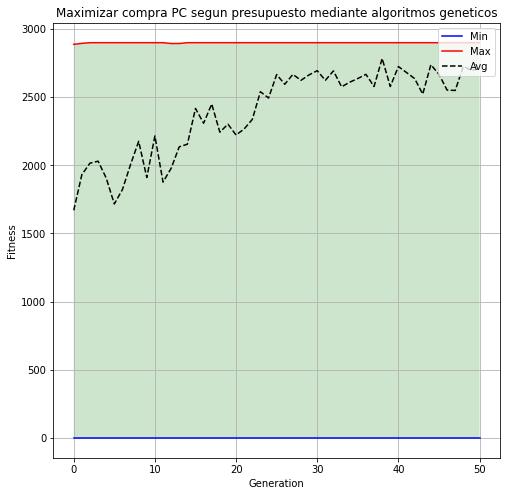

In [ ]:
plot_evolution(logs[1][1])

In [ ]:
PRODUCTS.iloc[[655, 693, 593, 207, 297, 427, 337, 27], :]

,title,type,category,range,symbol,price,link,origin
655,Procesador de escritorio MSI MEG Intel Core i7...,CPU,Gamer,High,US,629.0,https://www.amazon.com/-/es/Procesador-escrito...,/work/games_seeker/data/raw/amazon_procesadore...
693,MSI MPG Z590 Gaming Edge WiFi placa base para ...,Mother Board,Gamer,Mid,US,219.0,https://www.amazon.com/-/es/Gaming-juegos-gene...,/work/games_seeker/data/raw/amazon_tarjeta_mad...
593,Corsair Vengeance RGB Pro 16 GB (2 x 8 GB) DDR...,RAM,Office,Low,US,95.0,https://www.amazon.com/-/es/Corsair-Vengeance-...,/work/games_seeker/data/raw/amazon_memorias_ra...
207,WD_BLACK 2TB SN850 NVMe unidad de estado sólid...,Storage,Gamer,High,US,315.0,https://www.amazon.com/-/es/WD_BLACK-aleaci%C3...,/work/games_seeker/data/raw/amazon_nvme_m.2.csv
297,EVGA GeForce RTX 2060 XC Ultra Gaming,GPU,Gamer/Desing,Mid,US,699.0,https://www.amazon.com/-/es/EVGA-GeForce-2060-...,/work/games_seeker/data/raw/amazon_tarjetas_gr...
427,Wendry Kit de refrigeración por agua de 9.449 ...,Refrigeration,Office,Low,US,129.0,https://www.amazon.com/-/es/refrigeraci%C3%B3n...,/work/games_seeker/data/raw/amazon_refrigeraci...
337,"Corsair AXi Series, AX1600i, 1600 W, 80+ Titan...",Power Supply,Gamer,High,US,661.0,https://www.amazon.com/-/es/Corsair-AX1600i-Ti...,/work/games_seeker/data/raw/amazon_fuentes_de_...
27,Thermaltake carcasa de computadora,Chasis,Office,Low,US,149.0,https://www.amazon.com/-/es/CA-1H8-00M1WN-01-T...,/work/games_seeker/data/raw/amazon_chasis_para...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=07e29549-6cbf-4e88-b69c-0fc48f2d6023' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>